## Introductions:

The notebook includes the following sections: 

* Preparations: load libraries and data set
* Data Pre-processing: Pre-process data, train-test splot
* Naive Model: Test the first model given by the assignment.
* Improved Model: Record my whole process of building an improved model, starting with modeling only a quadratic trend, then justifying that a periodic function could model the seasonal variation, then combine components to build a complete model.
* Prediction: Make use of the completed model above to make predictions

Notation difference: The notebook uses x[n] to refer to the CO2 measurements, while the paper uses y[n]. 



## Preparations


In [0]:
!pip install pystan

In [0]:
from scipy import stats as sts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan
import seaborn
import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving weekly_co2_data.csv to weekly_co2_data (1).csv
User uploaded file "weekly_co2_data.csv" with length 55121 bytes


In [0]:
data = pd.read_csv('weekly_co2_data.csv')

In [0]:
data.head()

,Date,CO2
0,3/29/1958,316.19
1,4/5/1958,317.31
2,4/12/1958,317.69
3,4/19/1958,317.58
4,4/26/1958,316.48


## Data Pre-processing

In [0]:
start_date = datetime.datetime.strptime(data.Date.values.tolist()[0], '%m/%d/%Y') # convert column values from string to datetime
date_list = data.Date.values.tolist() # get values from date column 
for i in range(len(data)):
  tempt_d = datetime.datetime.strptime(date_list[i], '%m/%d/%Y')
  data.set_value(i,'Date',((tempt_d-start_date).days + 1)) # the plus one is so that the minimum value starts with 1. I used date to index in pystan before, and just go ahead with that numbering convention.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


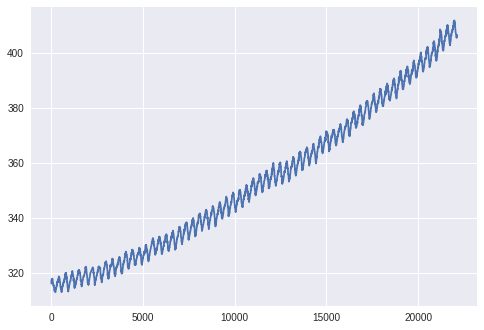

In [0]:
plt.plot(data['Date'].values.tolist(), data['CO2'].values.tolist()) # plot data

In [0]:
# train-test split
train, test = train_test_split(data, test_size=0.3, shuffle=False)

##Naive Model

### Model and Sampling

In [0]:
# stan code to feed into PyStan
stan_code_1 = """

// Known Quantities
data {
    int<lower=1> N;
    int<lower=0> t[N];
    real<lower=0> x[N];
    
    int <lower=1> N_new;
    real t_new[N_new];
     }

// Unknown parameters
parameters {
    real<lower=0> c[4];
    real<lower=-pi(), upper=pi()> c4;
}

// The model block contains all probability distributions in the model.
model {
    c[1] ~ cauchy(0,1);
    c[2] ~ normal(0,1);
    c[3] ~ cauchy(0,1);
    c4 ~ normal(0,pi());
    c[4]~ cauchy(0,1);

    
    for (i in 1:N){
        x[i] ~ normal(c[1] + c[2]*t[i] + c[3]*cos(2*pi()*t[i]/365.25 + c4), c[4]);
    }
    }
generated quantities {
    real<lower=0> x_new[N_new];
    for (i in 1:N_new){
        x_new[i] = normal_rng(c[1] + c[2]*t_new[i] + c[3]*cos(2*pi()*t_new[i]/365.25 + c4), c[4]);
    }
}

"""

In [0]:
stan_model_1 = pystan.StanModel(model_code=stan_code_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8201ad8b6ad701c0bb591a71dc01b2e NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpjpswd5yd/stanfit4anon_model_f8201ad8b6ad701c0bb591a71dc01b2e_765918832347801850.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
# Two models share the same train and test sets
# train set
CO2_values = train['CO2'].values.tolist()
date_values = train['Date'].values.tolist()
num_time_steps = len(CO2_values)

# test set
CO2_values_new = test['CO2'].values.tolist()
date_values_new = test['Date'].values.tolist()

In [0]:
# two models share the same data
stan_data = {
    'x': CO2_values,
    'N': num_time_steps,
    't': date_values,
    't_new': date_values_new,
    'N_new': len(date_values_new)
  }

In [0]:
st = time.time() # timer - measure the elapsed time. Get time when the cell starts running
# sample parameters and summarize results. High N_eff and Rhat=1.0 indicates that sampling is indeed working
parameters_1 = ['c', 'c4'] # specifies which parameters to get summary from
result_1 = stan_model_1.sampling(data=stan_data) # run model sampling
print(result_1.stansummary(pars=parameters_1)) # print summary for specified params.
print('Elapsed time: {}'.format(time.time()-st)) # print out elapsed time. 

Inference for Stan model: anon_model_f8201ad8b6ad701c0bb591a71dc01b2e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c[1]  310.4  1.4e-3   0.08 310.24 310.35  310.4 310.46 310.57   3793    1.0
c[2] 3.7e-3  1.4e-7 9.2e-6 3.6e-3 3.6e-3 3.7e-3 3.7e-3 3.7e-3   4416    1.0
c[3]   2.82  1.3e-3   0.06   2.71   2.78   2.82   2.86   2.94   2034    1.0
c[4]   1.89  5.9e-4   0.03   1.83   1.87   1.89   1.91   1.95   2300    1.0
c4    -0.47  4.4e-4   0.02  -0.51  -0.48  -0.47  -0.45  -0.42   2265    1.0

Samples were drawn using NUTS at Wed Dec 19 23:09:42 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Elapsed time: 215.73562455177307


### Result Evaluation

In [0]:
l = [] # samples a time series from the parameters obtained from Stan
samples = result['c'][0]
samples_c4 = result['c4'][0]
for i in range(num_time_steps):
  l.append(samples[0] + samples[1]*date_values[i] + samples[2]*np.cos(2*np.pi*date_values[i]/365.25+samples_c4)+sts.norm(loc=0,scale=samples[3]).rvs(1))

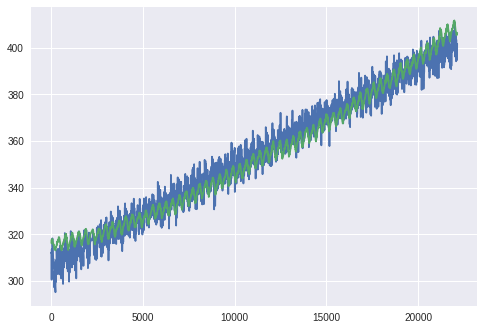

In [0]:
# plot the replicated data set (blue) and the real data set (green)
# too much uncertainty, not quite good
plt.plot(data['Date'].values.tolist(),l)
plt.plot(data['Date'].values.tolist(), data['CO2'].values.tolist())

In [0]:
# append all sampled values of the params.
plot_x = []
for i in range (5):
  if i == 3:
    plot_x.append([result['c4'][ctr] for ctr in range(4000)])
  if i == 4:
    plot_x.append([result['c'][ctr][3] for ctr in range(4000)])
  else:
    plot_x.append([result['c'][ctr][i] for ctr in range(4000)])

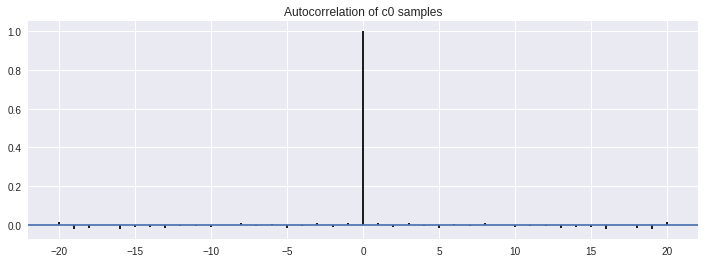

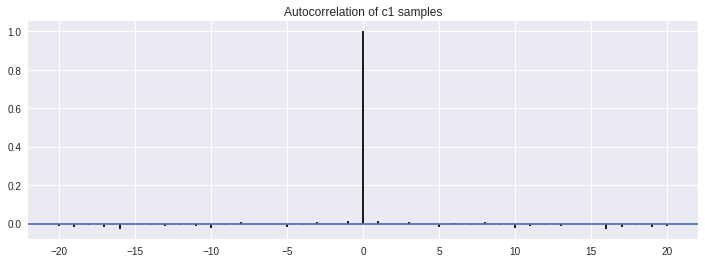

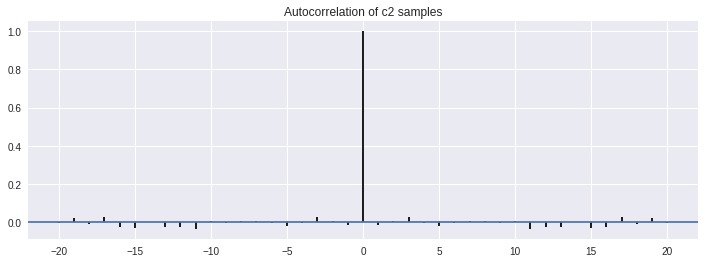

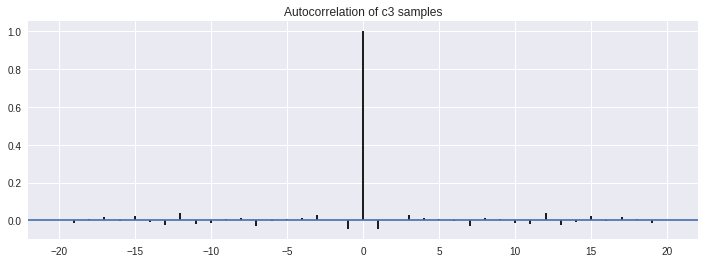

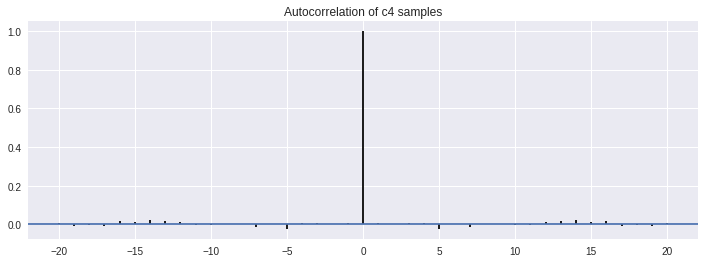

In [0]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for i in range(5):
    plt.figure(figsize=(12, 4))
    plot_acf(plot_x[i])
    plt.title(f'Autocorrelation of c{i} samples')
    plt.savefig('Autocorrelation_plot_linear_model_c{}.png'.format(i))
    files.download('Autocorrelation_plot_linear_model_c{}.png'.format(i))
plt.show()

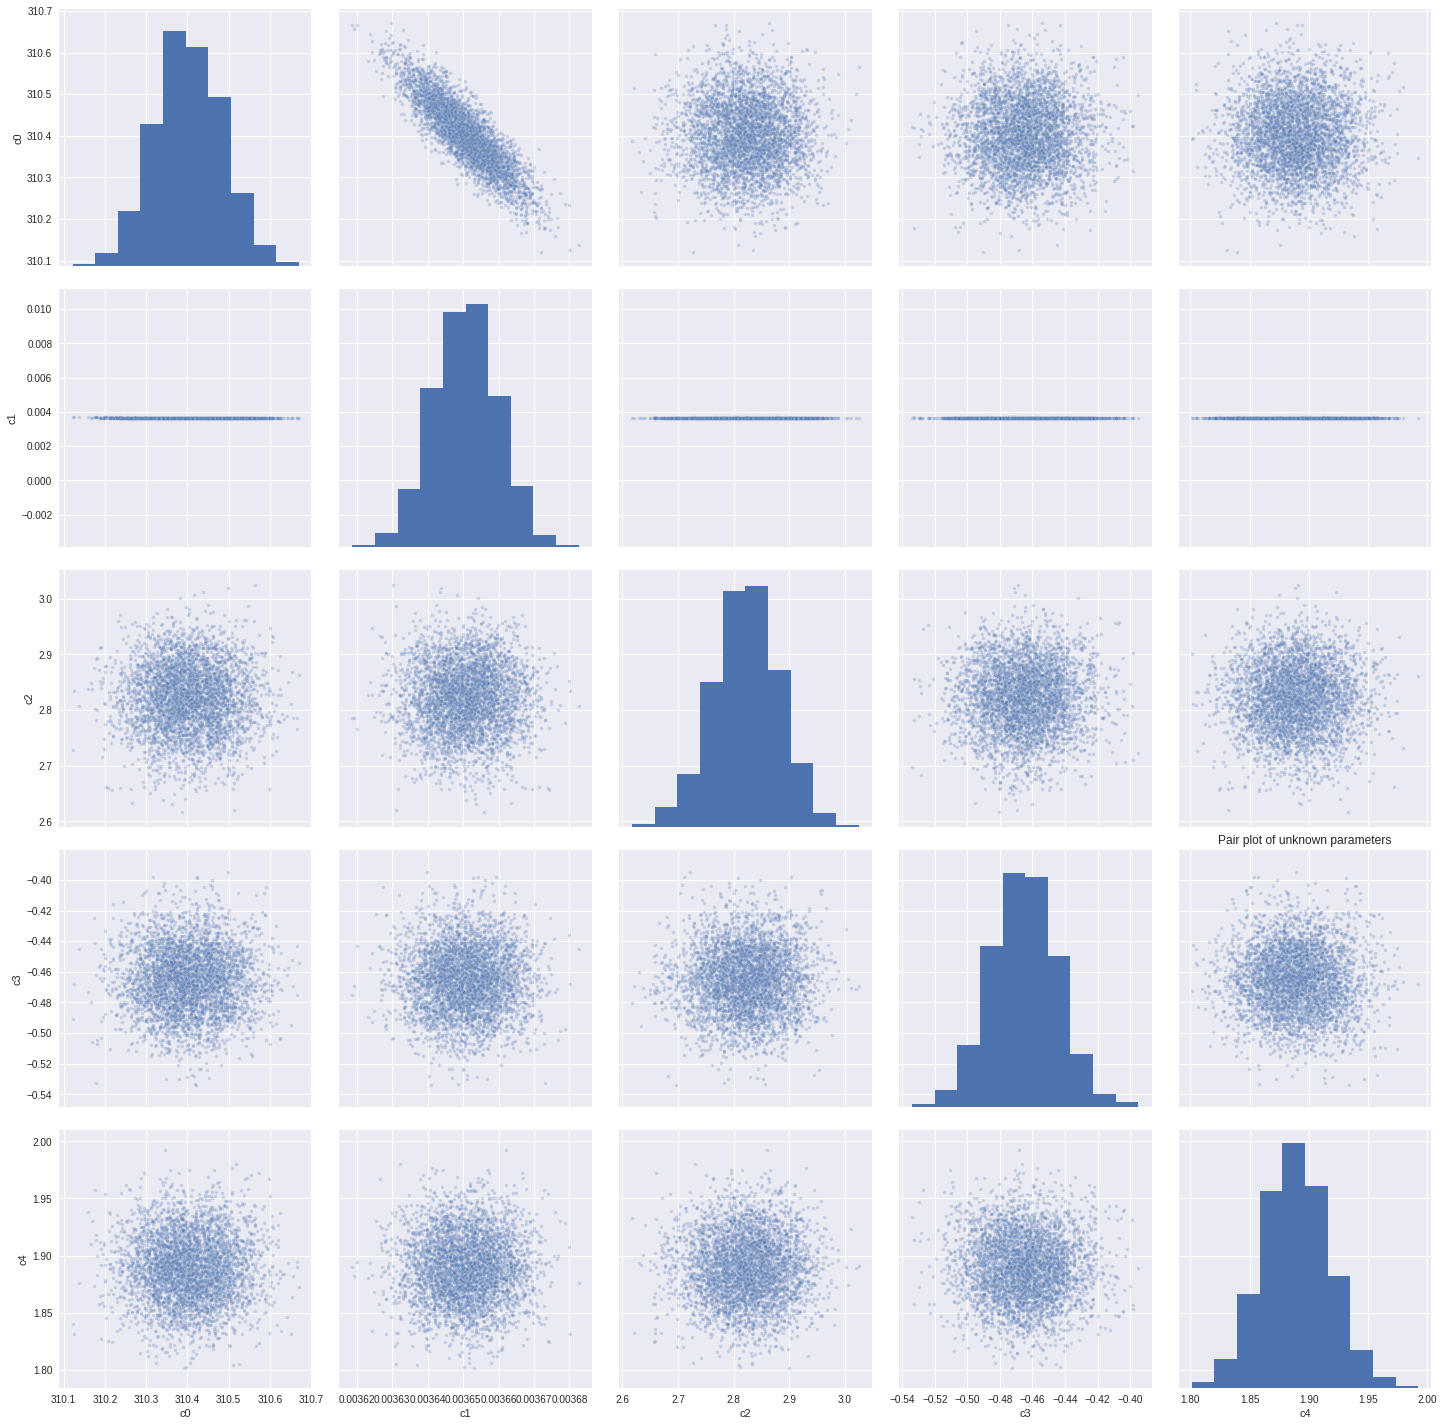

In [0]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([plot_x[i] for i in range(5)]),
    columns=['c0', 'c1', 'c2', 'c3', 'c4'])
seaborn.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.savefig('pair_plot_linear_model.png', bbox_inches='tight')
files.download('pair_plot_linear_model.png')
plt.show()

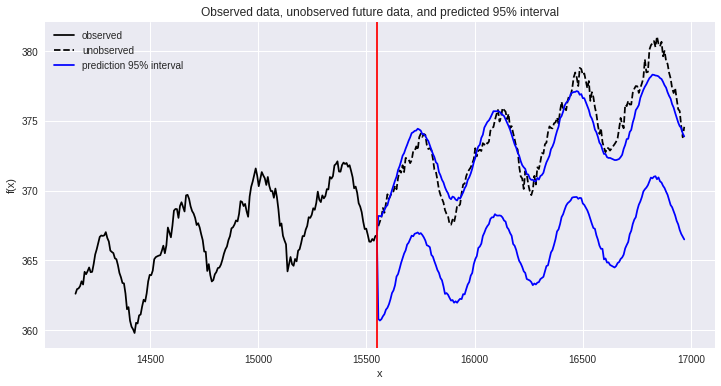

In [0]:
# generate graph between given data and predicted value, including confint
prediction = result['x_new'] # predictions
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5]) # condidence intervals

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(train['Date'].values.tolist()[-200:], train['CO2'].values.tolist()[-200:], 'k-', label='observed')
plt.plot(test['Date'].values.tolist()[:200], test['CO2'].values.tolist()[:200], 'k--', label='unobserved')

plt.plot(
    train['Date'].values.tolist()[-1:]+test['Date'].values.tolist()[:200],
    np.concatenate((train['CO2'].values.tolist()[-1:], prediction_interval[0,:200])),
    'b-', label='prediction 95% interval')
plt.plot(
    train['Date'].values.tolist()[-1:]+test['Date'].values.tolist()[:200],
    np.concatenate((train['CO2'].values.tolist()[-1:], prediction_interval[1,:200])),
    'b-')
plt.axvline(train['Date'].values.tolist()[-1], color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.savefig('test_set_linear_model.png')
files.download('test_set_linear_model.png')
plt.show()

In [0]:
# calculate MSE.
print ("MSE - Train - Linear trend: {}".format( metrics.mean_squared_error(train['CO2'].values.tolist(), l)))
print ("MSE - Test - Linear trend: {}".format( metrics.mean_squared_error(test['CO2'].values.tolist(), [*map(np.mean, zip(*prediction))])))

MSE - Train - Linear trend: 7.249666560856127
MSE - Test - Linear trend: 113.80133432985302


In [0]:
# despite the name, this is the array of the residuals
noise_seq = np.array(test['CO2'].values.tolist()) - np.array([*map(np.mean, zip(*prediction))])

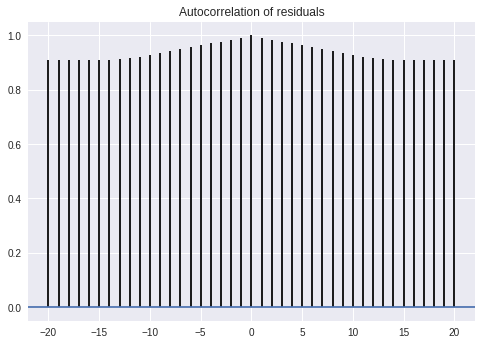

In [0]:
# Autocorrelation plot of residuals
plot_acf(noise_seq)
plt.title("Autocorrelation of residuals")
plt.savefig('autocorrelation_residual_linear_model.png')
files.download('autocorrelation_residual_linear_model.png')
plt.show()

In [0]:
# function to calculate the test statistic.
def test_statistic(data):
  """
  Reference: Class 10.2
  Test statistic - Calculate the proportion of data between [mu-sigma; mu+sigma]
  """
    mu = np.mean(data)  # sample mean
    sigma = np.std(data, ddof=1)  # sample standard deviation
    return np.mean((data > mu - sigma) & (data < mu + sigma))

In [0]:
# find test statistic of the real data.
test_statistic(train['CO2'].values.tolist()[-300:])

0.62

In [0]:
# generate list of 100 test statistics. I tried 1000 but that would take extremely long.
l_1 = []
samples_1 = result_1['c']
samples_c4_1 = result_1['c4']
for ctr in range(500):
  tempt_l = []
  for i in range(num_time_steps - 1300, num_time_steps - 1000):
    tempt_l.append(samples_1[ctr][0] + samples_1[ctr][1]*date_values[i] + samples_1[ctr][2]*np.cos(2*np.pi*date_values[i]/365.25+samples_c4_1[ctr])+sts.norm(loc=0,scale=samples_1[ctr][3]).rvs(1))
  l_1.append(test_statistic(tempt_l))

In [0]:
s = 0
orig_stat = test_statistic(train['CO2'].values.tolist()[num_time_steps - 1300: num_time_steps-1000])
for item in l_1:
    if item>orig_stat:
        s+=1
print (s/len(l_1))

0.78


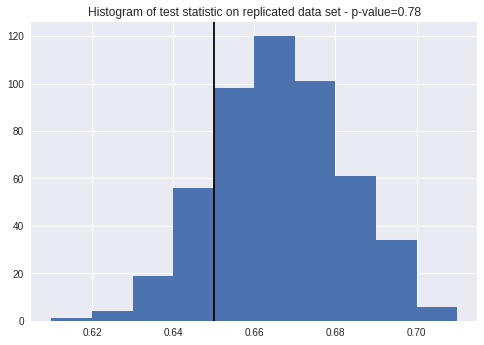

In [0]:
plt.hist(l_1)
plt.axvline(test_statistic(train['CO2'].values.tolist()[num_time_steps-1300:num_time_steps-1000]), color='black')
plt.title('Histogram of test statistic on replicated data set - p-value={}'.format(s/len(l_1)))
plt.savefig('test_stat_mid_300_linear_model.png')
files.download('test_stat_mid_300_linear_model.png')

## Improved Model

### Without Seasonal Variations

In [0]:
# simple model with no seasonal variations, just to test the water.
# stan code to feed into PyStan
stan_code = """

// Known Quantities
data {
    int<lower=1> N;
    int<lower=0> t[N];
    real<lower=0> x[N];
     }

// Unknown parameters
parameters {
    real<lower=0> c[4];  
    }

// The model block contains all probability distributions in the model.
model {
    for (i in 1:4){
        c[i] ~ cauchy(0,1);
    }
    
    for (i in 1:N){
        x[i] ~ normal(c[1] + c[2]*t[i] + c[3]*t[i]*t[i], c[4]);
    }
}
"""

In [0]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_805d3382ea04a9b66b9422738f79fa6b NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpkjt6mlod/stanfit4anon_model_805d3382ea04a9b66b9422738f79fa6b_92725296319506489.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
CO2_values = data['CO2'].values.tolist()
date_values = data['Date'].values.tolist()
num_time_steps = len(CO2_values)

In [0]:
stan_data = {
    'x': CO2_values,
    'N': num_time_steps,
    't': date_values
  }

In [0]:
st = time.time()
# sample parameters and summarize results. High N_eff and Rhat=1.0 indicates that sampling is indeed working
result = stan_model.sampling(data=stan_data)
print(result.stansummary())
print('Elapsed time: {}'.format(time.time()-st))

Inference for Stan model: anon_model_805d3382ea04a9b66b9422738f79fa6b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c[1]  314.5  3.5e-3   0.12 314.26 314.42  314.5 314.58 314.74   1235    1.0
c[2] 2.1e-3  8.0e-7 2.5e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.2e-3   1001    1.0
c[3] 9.6e-8 3.5e-11 1.1e-9 9.4e-8 9.5e-8 9.6e-8 9.7e-8 9.8e-8   1030    1.0
c[4]   2.24  6.9e-4   0.03   2.19   2.22   2.24   2.26    2.3   1551    1.0
lp__  -4071    0.04   1.34  -4074  -4072  -4071  -4070  -4069   1353    1.0

Samples were drawn using NUTS at Tue Dec 18 20:10:55 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Elapsed time: 183.504709482193


In [0]:
l = []
samples = result['c'][0]
for i in range(num_time_steps):
  l.append(samples[0] + samples[1]*date_values[i] + samples[2]*date_values[i]**2 + sts.norm(loc=0,scale=samples[3]).rvs(1))

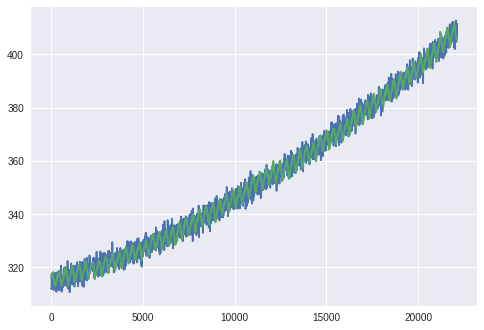

In [0]:
plt.plot(data['Date'].values.tolist(),l)
plt.plot(data['Date'].values.tolist(), data['CO2'].values.tolist())

In [0]:
metrics.mean_squared_error(data['CO2'].values.tolist(), l)

9.924172218640857

In [0]:
# get the data after subtracting the quadratic trend
l_detrend = []
for i in range(num_time_steps):
  l_detrend.append(data['CO2'].values.tolist()[i] - l[i])

In [0]:
l_detrend[0]

array([4.01582707])

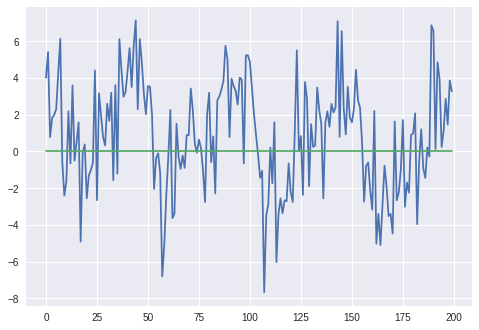

In [0]:
# plot seasonal variations.
plt.plot(l_detrend[:200])
plt.plot(list(range(200)), [0 for i in range(200)])

### Find Seasonal Variations

In [0]:
# stan code to feed into PyStan
stan_code = """

// Known Quantities
data {
    int<lower=1> N;
    int<lower=0> t[N];
    real x[N];
     }

// Unknown parameters
parameters {
    real<lower=0> c[3];  // unknown parameters lambda to be fed into the exponential lambda likelihood dist
    real<lower=-pi(), upper=pi()> epsilon;
    }

// The model block contains all probability distributions in the model.
model {
    for (i in 1:3){
        c[i] ~ cauchy(0,1);
    }
    epsilon ~ cauchy(0,1);
    
    for (i in 1:N){
        x[i] ~ normal(c[1]*cos(2*pi()*t[i]/365.25 + epsilon) + c[2], c[3]);
    }
}
"""

In [0]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0c2803c673178b3b0ed041b116d1be9f NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpsmb7jcuh/stanfit4anon_model_0c2803c673178b3b0ed041b116d1be9f_8218782823250414579.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
l_detrend = [l_detrend[i][0] for i in range(len(l_detrend))]

In [0]:
CO2_values = l_detrend
date_values = data['Date'].values.tolist()
num_time_steps = len(CO2_values)

In [0]:
stan_data = {
    'x': CO2_values,
    'N': num_time_steps,
    't': date_values
  }

In [0]:
# TAKE VERY LONG FOR SAMPLING
st = time.time()
# sample parameters and summarize results. High N_eff and Rhat=1.0 indicates that sampling is indeed working
result = stan_model.sampling(data=stan_data)
print(result.stansummary())
print('Elapsed time: {}'.format(time.time()-st))

Inference for Stan model: anon_model_0c2803c673178b3b0ed041b116d1be9f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c[1]      2.87  1.0e-3   0.06   2.75   2.83   2.87   2.91   2.99   3596    1.0
c[2]      0.06  7.0e-4   0.03 3.7e-3   0.03   0.05   0.08   0.13   2429    1.0
c[3]      2.41  5.3e-4   0.03   2.35   2.39   2.41   2.43   2.47   3581    1.0
epsilon  -0.48  3.5e-4   0.02  -0.52  -0.49  -0.48  -0.46  -0.43   3601    1.0
lp__     -4266    0.04   1.56  -4270  -4267  -4266  -4265  -4264   1241    1.0

Samples were drawn using NUTS at Tue Dec 18 23:04:08 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Elapsed time: 44.838592529296875


In [0]:
samples = result['c'][0]
sample_epsilon = result['epsilon'][0]
periodic_x = [samples[0]*np.cos(2*np.pi*date_values[i]/365.25 + sample_epsilon) for i in range(len(date_values))]

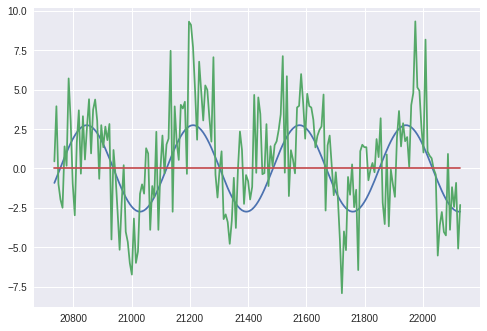

In [0]:
plt.plot(date_values[-200:], periodic_x[-200:])
plt.plot(date_values[-200:], l_detrend[-200:])
plt.plot(date_values[-200:], [0 for i in range(200)])

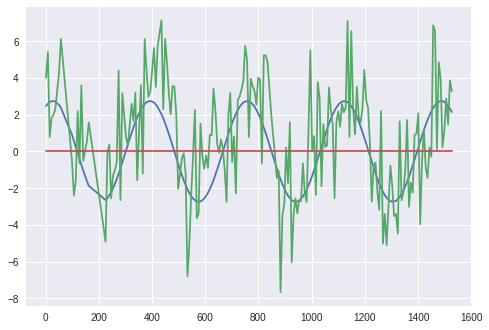

In [0]:
plt.plot(date_values[:200], periodic_x[:200])
plt.plot(date_values[:200], l_detrend[:200])
plt.plot(date_values[:200], [0 for i in range(200)])

In [0]:
noise_seq = [l_detrend[i] - periodic_x[i] for i in range(len(l_detrend))]

In [0]:
metrics.mean_squared_error(l_detrend, [periodic_x[i] for i in range(len(periodic_x))])

11.402740254623037

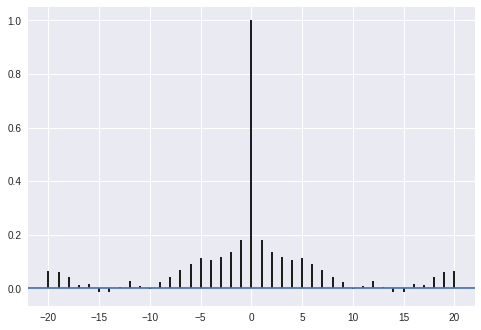

In [0]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))
plot_acf(noise_seq)

(array([ 18.,  93., 202., 549., 682., 765., 481., 226.,  54.,  21.]),
 array([-7.51961686, -5.99545977, -4.47130267, -2.94714558, -1.42298849,
         0.1011686 ,  1.62532569,  3.14948278,  4.67363987,  6.19779696,
         7.72195405]),
 <a list of 10 Patch objects>)

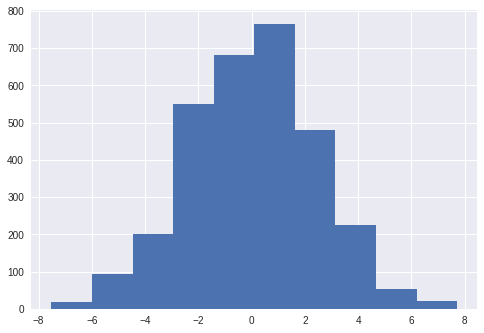

In [0]:
plt.hist(noise_seq)

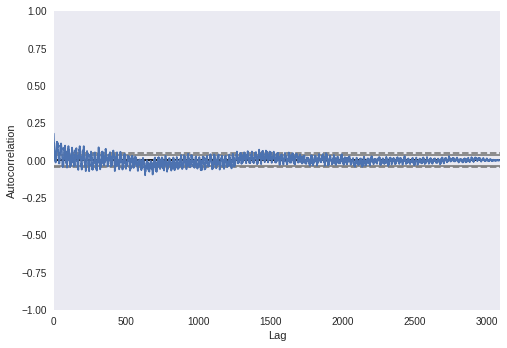

In [0]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(noise_seq)

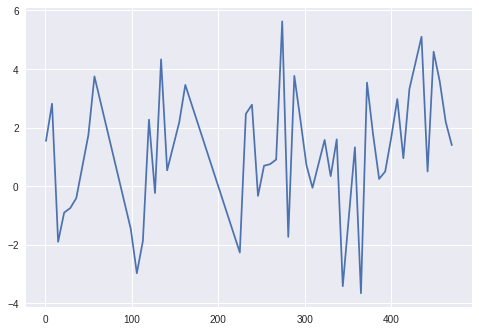

In [0]:
plt.plot(date_values[:50], noise_seq[:50])

### Test Predictions

In [0]:
# stan code to feed into PyStan
stan_code = """

// Known Quantities
data {
    int<lower=1> N; // counter variable for training
    int<lower=0> t[N]; // time step quantites
    real x[N]; // recorded CO2 amounts
    
    int <lower=1> N_new; // counter variable for prediction
    real t_new[N_new]; // time steps for prediction
     }

// Unknown parameters
parameters {
    real<lower=0> c[5];  // unknown parameters of the model
    real<lower=-pi(), upper=pi()> epsilon; // unknown phase parameter - initiated separately as it has different constraints
    }

// The model block contains all probability distributions in the model.
model {

    // distributions of unknown parameters
    c[1] ~ cauchy(0,1);
    c[2] ~ normal(0,1);
    c[3] ~ normal(0,1);
    epsilon ~ normal(0,4);
    c[4] ~ cauchy(0,1);
    c[5] ~ cauchy(0,1);
    
    for (i in 1:N){
        x[i] ~ normal(c[1] + c[2]*t[i] + c[3]*t[i]*t[i]  + c[4]*cos(2*pi()*t[i]/365.25 + epsilon), c[5]);
    }
}

generated quantities {
    // predictions
    real<lower=0> x_new[N_new];
    for (i in 1:N_new){
        x_new[i] = normal_rng(c[1] + c[2]*t_new[i] + c[3]*t_new[i]*t_new[i] + c[4]*cos(2*pi()*t_new[i]/365.25 + epsilon), c[5]);
    }
}
"""

In [0]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_172a37f873cf862a18ccf5f7ea6e8bae NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpl0eh2_fc/stanfit4anon_model_172a37f873cf862a18ccf5f7ea6e8bae_6331720298337434085.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
# train set
CO2_values = train['CO2'].values.tolist()
date_values = train['Date'].values.tolist()
num_time_steps = len(CO2_values)

# test set
CO2_values_new = test['CO2'].values.tolist()
date_values_new = test['Date'].values.tolist()

In [0]:
stan_data = {
    'x': CO2_values,
    'N': num_time_steps,
    't': date_values,
    't_new': date_values_new,
    'N_new': len(date_values_new)
  }

In [0]:
st = time.time()
# sample parameters and summarize results. High N_eff and Rhat=1.0 indicates that sampling is indeed working
parameters = ['c', 'epsilon']
result = stan_model.sampling(data=stan_data)
print(result.stansummary(pars=parameters))
print('Elapsed time: {}'.format(time.time()-st))

Inference for Stan model: anon_model_172a37f873cf862a18ccf5f7ea6e8bae.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c[1]    314.25  1.4e-3   0.06 314.11  314.2 314.25 314.29 314.37   2256    1.0
c[2]    2.2e-3  4.3e-7 1.9e-5 2.2e-3 2.2e-3 2.2e-3 2.2e-3 2.3e-3   1844    1.0
c[3]    9.1e-8 2.7e-11 1.1e-9 8.9e-8 9.0e-8 9.1e-8 9.2e-8 9.3e-8   1822    1.0
c[4]      2.81  5.8e-4   0.03   2.75   2.79   2.81   2.83   2.87   2523    1.0
c[5]      0.96  3.0e-4   0.01   0.93   0.95   0.96   0.97   0.99   2502    1.0
epsilon  -0.45  2.0e-4   0.01  -0.47  -0.46  -0.45  -0.45  -0.43   2845    1.0

Samples were drawn using NUTS at Wed Dec 19 22:37:41 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Elapsed time: 524.8317749500275


In [0]:
plot_x = []
for i in range (6):
  if i == 4:
    plot_x.append([result['epsilon'][ctr] for ctr in range(4000)])
  if i == 5:
    plot_x.append([result['c'][ctr][3] for ctr in range(4000)])
  else:
    plot_x.append([result['c'][ctr][i] for ctr in range(4000)])

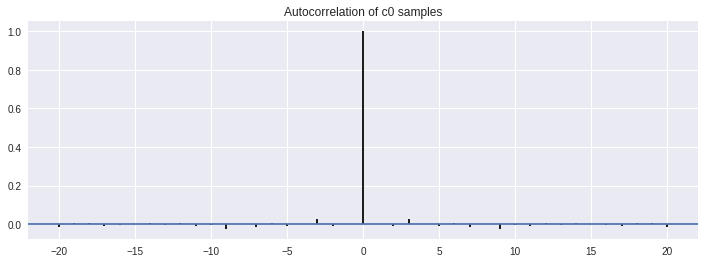

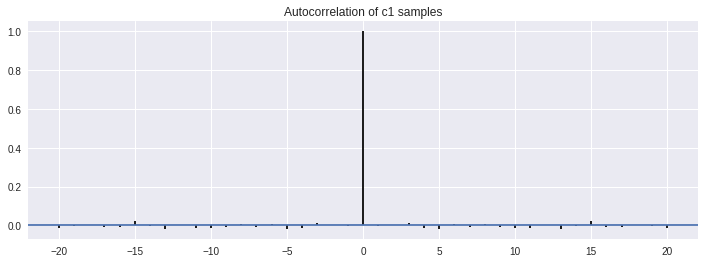

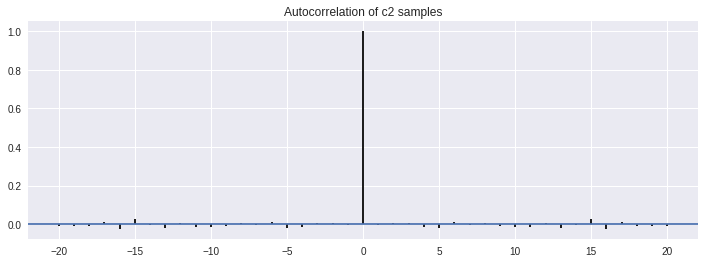

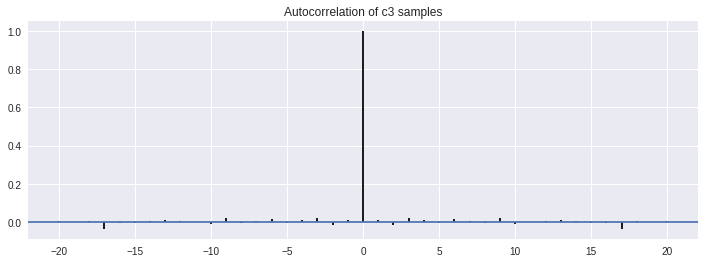

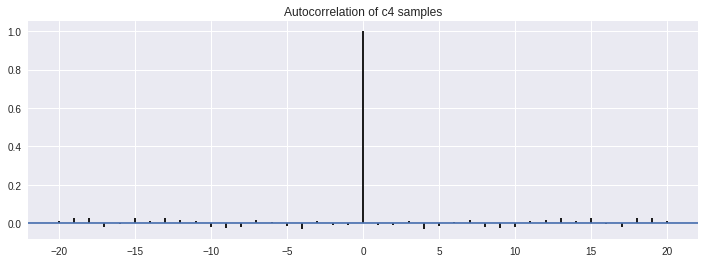

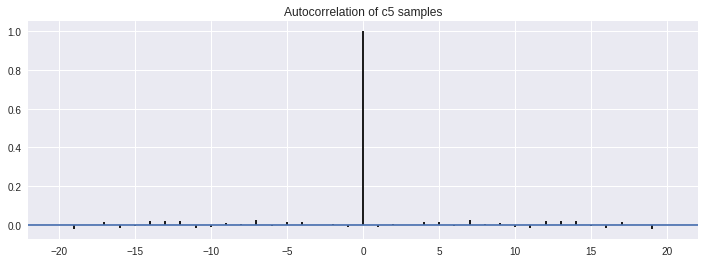

In [0]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for i in range(6):
    plt.figure(figsize=(12, 4))
    plot_acf(plot_x[i])
    plt.title(f'Autocorrelation of c{i} samples')
    plt.savefig('Autocorrelation_plot_quadratic_model_c{}.png'.format(i))
    files.download('Autocorrelation_plot_quadratic_model_c{}.png'.format(i))
plt.show()

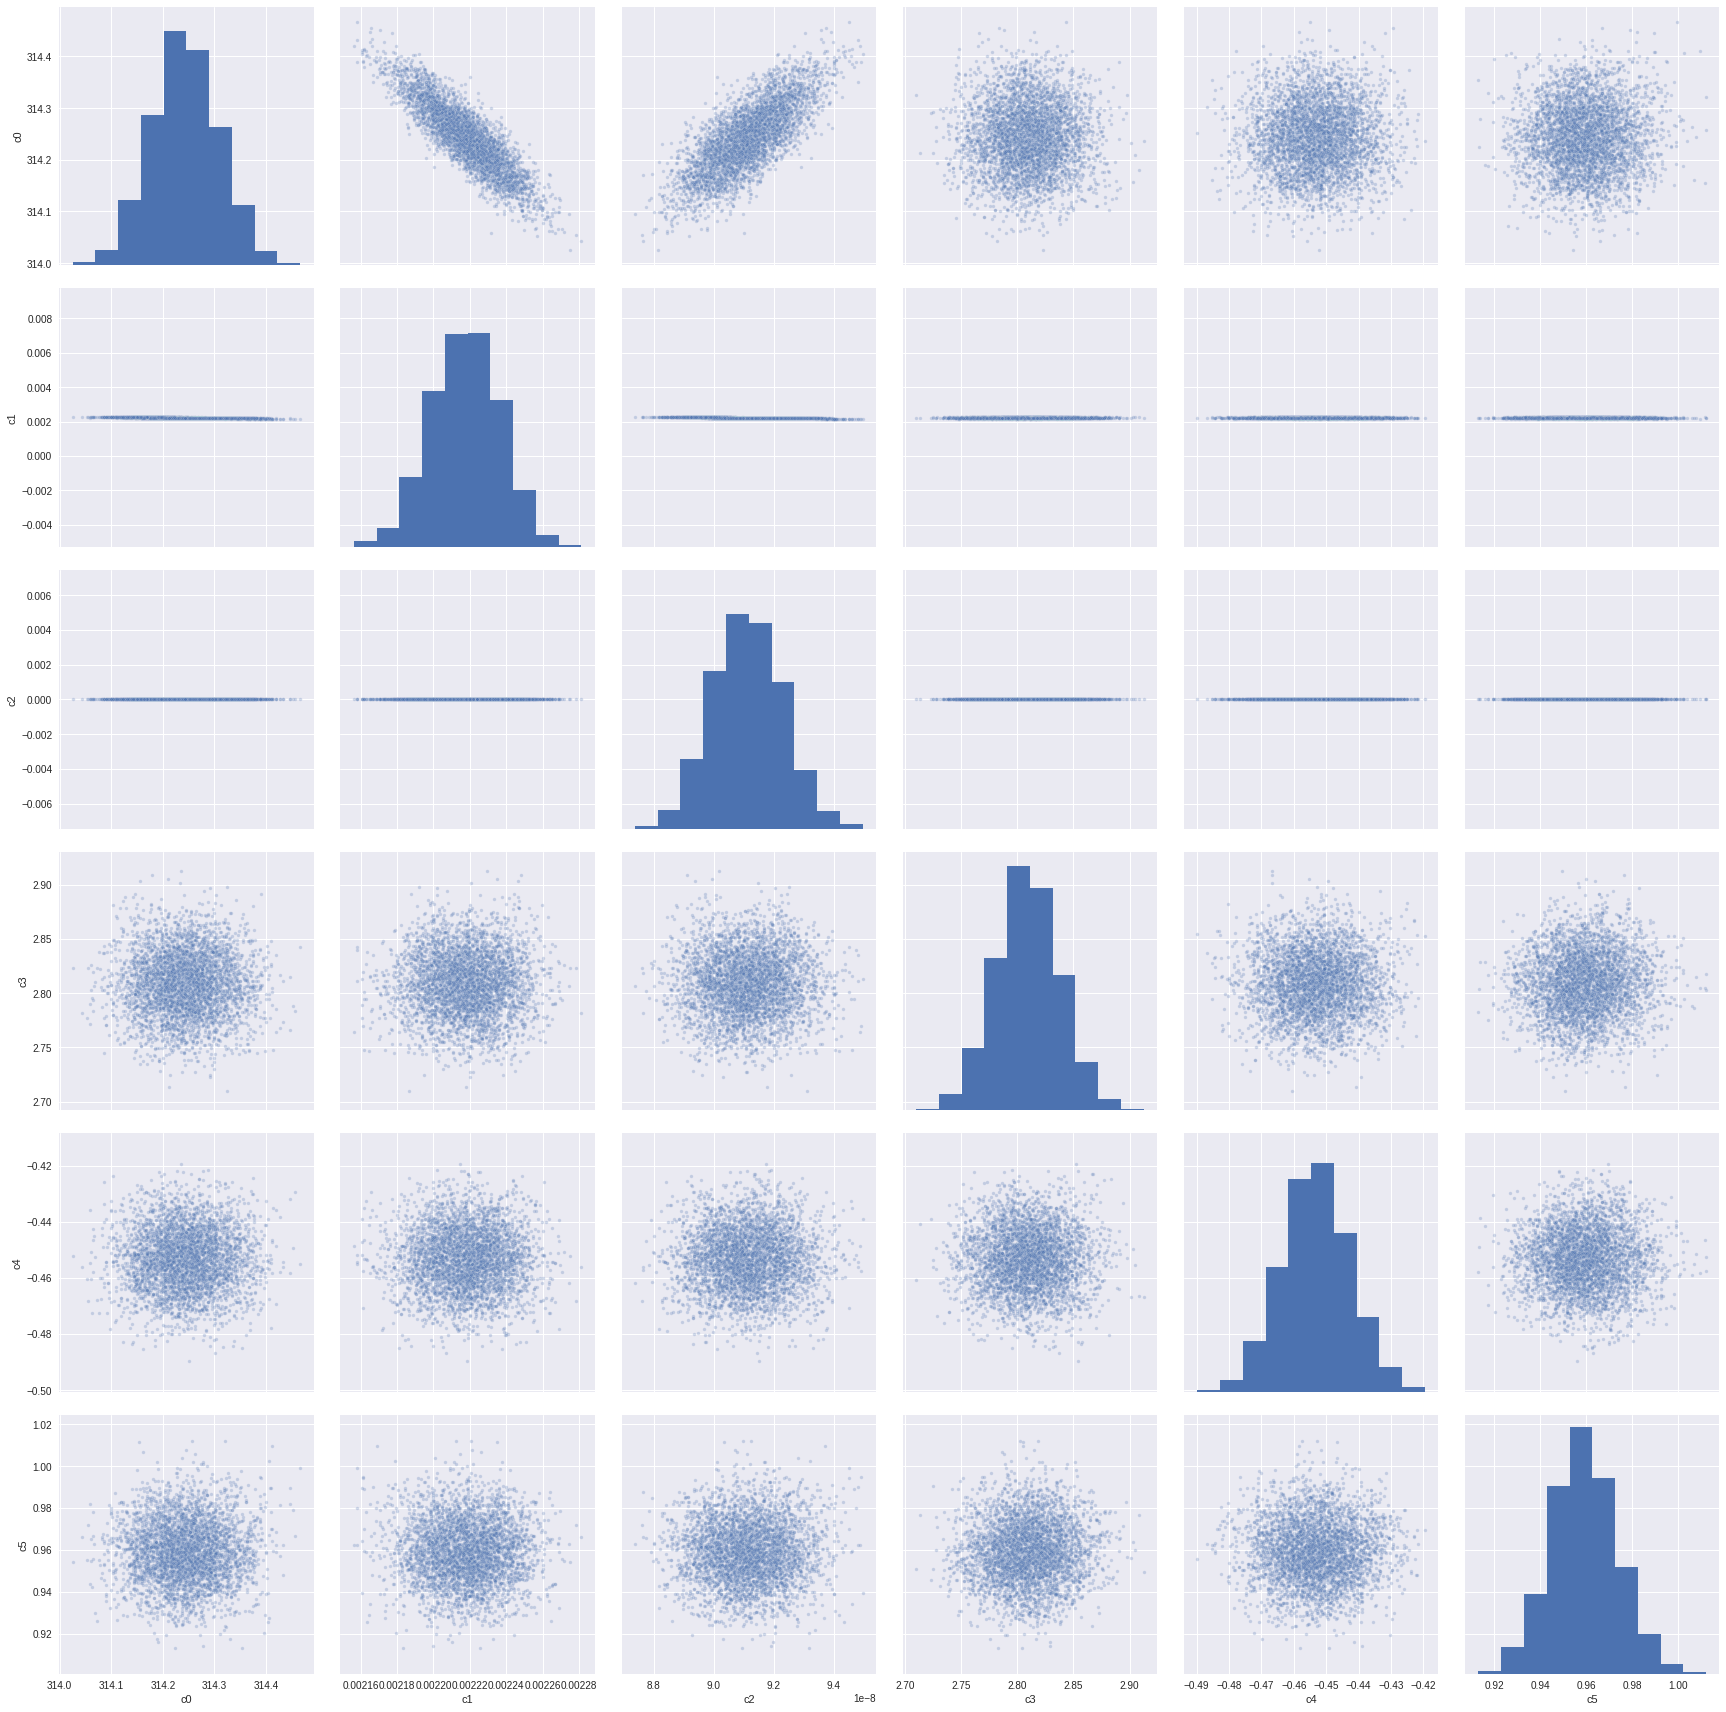

In [0]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([plot_x[i] for i in range(6)]),
    columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5'])
seaborn.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.savefig('pair_plot_quadratic_model.png', bbox_inches='tight')
files.download('pair_plot_quadratic_model.png')
plt.show()

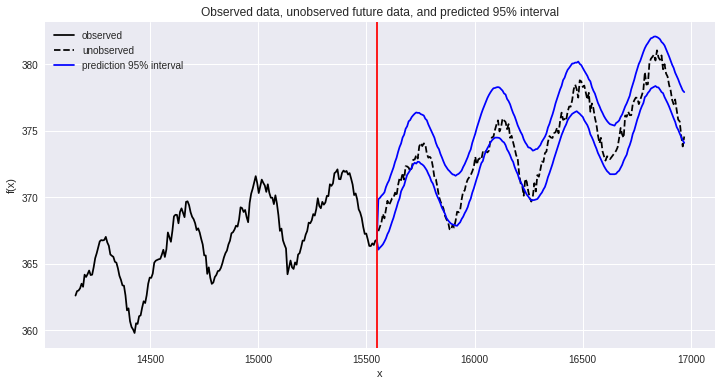

In [0]:
prediction = result['x_new']
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(train['Date'].values.tolist()[-200:], train['CO2'].values.tolist()[-200:], 'k-', label='observed')
plt.plot(test['Date'].values.tolist()[:200], test['CO2'].values.tolist()[:200], 'k--', label='unobserved')

plt.plot(
    train['Date'].values.tolist()[-1:]+test['Date'].values.tolist()[:200],
    np.concatenate((train['CO2'].values.tolist()[-1:], prediction_interval[0,:200])),
    'b-', label='prediction 95% interval')
plt.plot(
    train['Date'].values.tolist()[-1:]+test['Date'].values.tolist()[:200],
    np.concatenate((train['CO2'].values.tolist()[-1:], prediction_interval[1,:200])),
    'b-')
plt.axvline(train['Date'].values.tolist()[-1], color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
#plt.savefig('test_set_quadratic_model.png')
#files.download('test_set_quadratic_model.png')
plt.show()

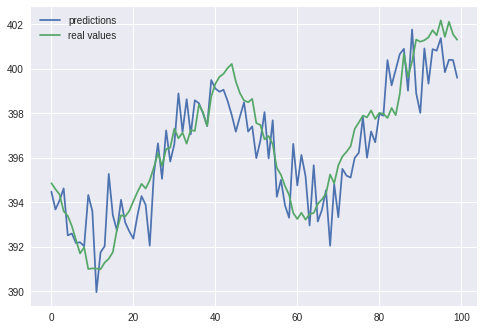

In [0]:
# plotting for sanity check
plt.plot(prediction[0][600:700], label="predictions")
plt.plot(test.CO2.values.tolist()[600:700], label="real values")
plt.legend()

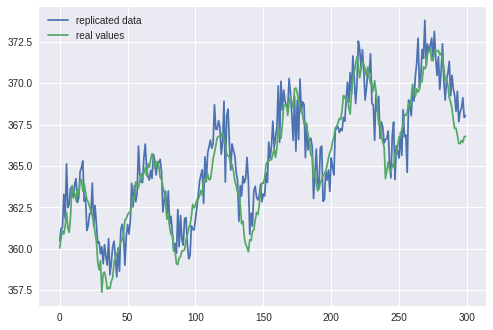

In [0]:
# plotting for sanity check
plt.plot(l[-300:], label="replicated data")
plt.plot(train.CO2.values.tolist()[-300:], label="real values")
plt.legend()

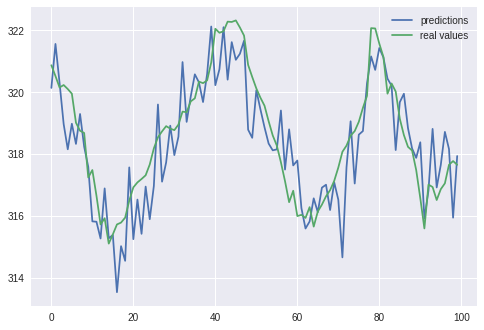

In [0]:
# plotting for sanity check
plt.plot(l[200:300],label="predictions")
plt.plot(train.CO2.values.tolist()[200:300],label="real values")
plt.legend()

In [0]:
# generate replicated data and try test statistic
l = []
samples = result['c'][104]
samples_c4 = result['epsilon'][104]
for i in range(num_time_steps):
  l.append(samples[0] + samples[1]*date_values[i] + samples[2]*date_values[i]**2 + samples[3]*np.cos(2*np.pi*date_values[i]/365.25+samples_c4)+sts.norm(loc=0,scale=samples[4]).rvs(1))
print (len(l))
test_statistic(l[-300:])

2163


0.65

In [0]:
# calculate MSE.
print ("MSE - Train - Quadratic trend: {}".format( metrics.mean_squared_error(train['CO2'].values.tolist(), l)))
print ("MSE - Test - Quadratic trend: {}".format( metrics.mean_squared_error(test['CO2'].values.tolist(), [*map(np.mean, zip(*prediction))])))

MSE - Train - Quadratic trend: 1.9356257723253665
MSE - Test - Quadratic trend: 1.137446871165131


In [0]:
# despite the name, this is the array of the residuals
noise_seq = np.array(test['CO2'].values.tolist()) - np.array([*map(np.mean, zip(*prediction))])

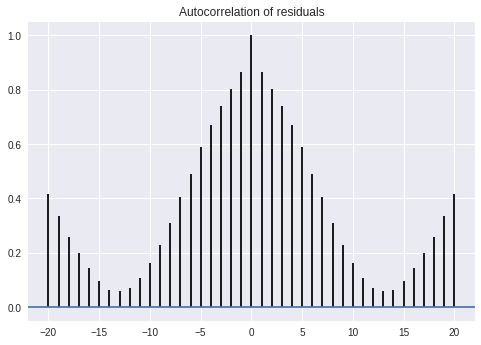

In [0]:
# Autocorrelation plot of residuals
plot_acf(noise_seq)
plt.title("Autocorrelation of residuals")
plt.savefig('autocorrelation_residual_quadratic_model.png')
files.download('autocorrelation_residual_quadratic_model.png')
plt.show()

In [0]:
# function to calculate the test statistic.
def test_statistic(data):
  """
  Reference: Class 10.2
  Test statistic - Calculate the proportion of data between [mu-sigma; mu+sigma]
  """
  mu = np.mean(data)  # sample mean
  sigma = np.std(data, ddof=1)  # sample standard deviation
  return np.mean((data > mu - sigma) & (data < mu + sigma))

In [0]:
# generate list of 100 test statistics. I tried 1000 but that would take extremely long.
l = []
samples = result['c']
samples_c4 = result['epsilon']
for ctr in range(500):
  tempt_l = []
  for i in range(300): #num_time_steps
    tempt_l.append(samples[ctr][0] + samples[ctr][1]*date_values[i] + samples[ctr][2]*date_values[i]**2 + samples[ctr][3]*np.cos(2*np.pi*date_values[i]/365.25+samples_c4[ctr])+sts.norm(loc=0,scale=samples[ctr][4]).rvs(1))
  l.append(test_statistic(tempt_l))

In [0]:
# calculate p-value
s = 0
orig_stat = test_statistic(train['CO2'].values.tolist()[:300])
for item in l:
    if item>orig_stat:
        s+=1
print (s/len(l))

0.706


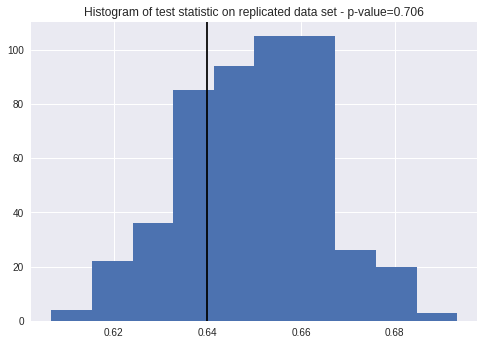

In [0]:
# plot histogram and p-value
plt.hist(l)
plt.axvline(test_statistic(train['CO2'].values.tolist()[:300]), color='black')
plt.title('Histogram of test statistic on replicated data set - p-value={}'.format(s/len(l)))
plt.savefig('test_stat_mid_300_quadratic_model.png')
files.download('test_stat_mid_300_quadratic_model.png')

## Prediction

In [0]:
new_data = pd.read_csv('weekly_co2_data.csv')
first_data_point = new_data.at[0,'Date']

In [0]:
last_date = (datetime.datetime(2058,1,1)-datetime.datetime.strptime(first_data_point, "%m/%d/%Y")).days + 4

In [0]:
unobserved_dates = list(range(data.at[len(data)-1,'Date']-1, last_date+1))[::7]

In [0]:
data.tail()

,Date,CO2
3086,22100,405.56
3087,22107,405.56
3088,22114,405.91
3089,22121,406.42
3090,22128,406.51


In [0]:
unobserved_dates = np.array(unobserved_dates) + 1
unobserved_dates = unobserved_dates[1:]

In [0]:
# stan code to feed into PyStan
stan_code = """

// Known Quantities
data {
    int<lower=1> N; // counter variable for training
    int<lower=0> t[N]; // time step quantites
    real x[N]; // recorded CO2 amounts
    
    int <lower=1> N_new; // counter variable for prediction
    real t_new[N_new]; // time steps for prediction
     }

// Unknown parameters
parameters {
    real<lower=0> c[5];  // unknown parameters of the model
    real<lower=-pi(), upper=pi()> epsilon; // unknown phase parameter - initiated separately as it has different constraints
    }

// The model block contains all probability distributions in the model.
model {

    // distributions of unknown parameters
    c[1] ~ cauchy(0,1);
    c[2] ~ normal(0,1);
    c[3] ~ normal(0,1);
    epsilon ~ normal(0,4);
    c[4] ~ cauchy(0,1);
    c[5] ~ cauchy(0,1);
    
    for (i in 1:N){
        x[i] ~ normal(c[1] + c[2]*t[i] + c[3]*t[i]*t[i]  + c[4]*cos(2*pi()*t[i]/365.25 + epsilon), c[5]);
    }
}

generated quantities {
    // predictions
    real<lower=0> x_new[N_new];
    for (i in 1:N_new){
        x_new[i] = normal_rng(c[1] + c[2]*t_new[i] + c[3]*t_new[i]*t_new[i] + c[4]*cos(2*pi()*t_new[i]/365.25 + epsilon), c[5]);
    }
}
"""

In [0]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_172a37f873cf862a18ccf5f7ea6e8bae NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpmz0qv48h/stanfit4anon_model_172a37f873cf862a18ccf5f7ea6e8bae_4046576219349223970.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
CO2_values = data['CO2'].values.tolist()
date_values = data['Date'].values.tolist()
num_time_steps = len(CO2_values)
date_values_new = unobserved_dates

In [0]:
stan_data = {
    'x': CO2_values,
    'N': num_time_steps,
    't': date_values,
    't_new': date_values_new,
    'N_new': len(date_values_new)
  }

In [0]:
# TAKE VERY LONG FOR SAMPLING
st = time.time()
# sample parameters and summarize results. High N_eff and Rhat=1.0 indicates that sampling is indeed working
parameters = ['c', 'epsilon']
result = stan_model.sampling(data=stan_data)
print(result.stansummary(pars=parameters))
print('Elapsed time: {}'.format(time.time()-st))

Inference for Stan model: anon_model_172a37f873cf862a18ccf5f7ea6e8bae.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c[1]  314.5  1.3e-3   0.05  314.4 314.47  314.5 314.54 314.61   1831    1.0
c[2] 2.1e-3  2.9e-7 1.1e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.2e-3   1478    1.0
c[3] 9.6e-8 1.2e-114.8e-10 9.5e-8 9.5e-8 9.6e-8 9.6e-8 9.7e-8   1493    1.0
c[4]   2.86  4.7e-4   0.03   2.81   2.84   2.86   2.87   2.91   2936    1.0
c[5]   0.97  2.4e-4   0.01   0.95   0.96   0.97   0.98    1.0   2619    1.0

Samples were drawn using NUTS at Thu Dec 20 12:11:28 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Elapsed time: 896.7771079540253


In [0]:
# get predictions
prediction = result['x_new']
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

In [0]:
# despite the name, std_list are actually containing the width of the confint over each predicted data point
std_list = []
for i in range (len (date_values_new)): # to avoid oversampling, recorded confint interval every 10 steps only
  if i % 10 == 0:
    std_list.append(prediction_interval[1,i] - prediction_interval[0,i])

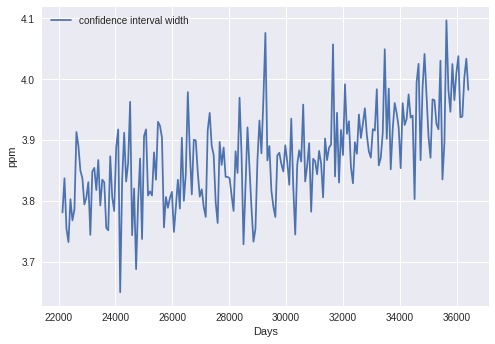

In [0]:
# plot confint width over time.
plt.plot(date_values_new[::10], std_list, label="confidence interval width")
plt.xlabel('Days')
plt.ylabel('ppm')
plt.legend()
plt.savefig('predictions_confint.png')
files.download('predictions_confint.png')
plt.show()

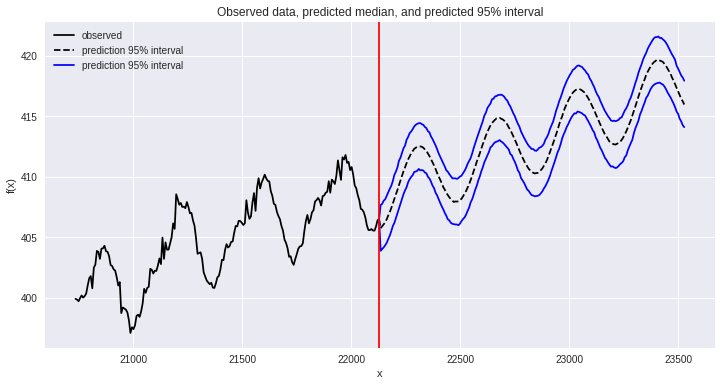

In [0]:
# make predictions
prediction = result['x_new']
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 50, 97.5])
new_x = [data.Date.values.tolist()[-1]] + list(date_values_new[:200])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(data['Date'].values.tolist()[-200:], data['CO2'].values.tolist()[-200:], 'k-', label='observed')

plt.plot(
    new_x,
    np.concatenate((data['CO2'].values.tolist()[-1:], prediction_interval[1,:200])),
    'k--', label='prediction 95% interval')
plt.plot(
    new_x,
    np.concatenate((data['CO2'].values.tolist()[-1:], prediction_interval[0,:200])),
    'b-', label='prediction 95% interval')
plt.plot(
    new_x,
    np.concatenate((data['CO2'].values.tolist()[-1:], prediction_interval[2,:200])),
    'b-')
plt.axvline(data['Date'].values.tolist()[-1], color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Observed data, predicted median, and predicted 95% interval')
plt.savefig('val_set_quadratic_model.png')
files.download('val_set_quadratic_model.png')
plt.show()

In [0]:
# get prediction for the critical level of CO2
for i in range(len(prediction_interval[1,:])):
  if prediction_interval[1,i] >= 450:
    crit_day = date_values_new[i]
    print (date_values_new[i])
    break

27763


In [0]:
# convert back to date time
datetime.datetime(1958,3,29)+datetime.timedelta(days=int(crit_day)-1)

datetime.datetime(2034, 4, 1, 0, 0)